In [1]:
#default_exp suite

# Model Suite

<br>

### Imports

In [2]:
#exports
import yaml
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split

from evtdemand import data, feature

from tqdm import tqdm
from random import randint
from typing import Protocol
from importlib import import_module

import matplotlib.pyplot as plt

In [3]:
from IPython.display import JSON

In [104]:
#exports
class ScikitModel(Protocol):
    def fit(self, X, y, sample_weight=None): ...
    def predict(self, X): ...
    def score(self, X, y, sample_weight=None): ...
    def set_params(self, **params): ...
    
def create_train_test_indexes(X, **split_kwargs):
    if 'n_splits' not in split_kwargs.keys():
        assert 'test_size' in split_kwargs.keys(), 'You must provide either `n_splits` or `test_size` within the `split_kwargs` parameters'
        size = X.shape[0]
        index_array = np.linspace(0, size-1, size).astype(int)
        train_test_indexes = [tuple(train_test_split(index_array, **split_kwargs))]
    else:
        kf = KFold(**split_kwargs)
        train_test_indexes = kf.split(X)
        
    return train_test_indexes
    
def calculate_error_metrics(y1, y2, y1_pred, y2_pred, y_baseline):
    baseline_combined_rmse = np.sqrt(np.square(y_baseline - y1).sum() + np.square(y_baseline - y2).sum())
    combined_rmse = np.sqrt(np.square(y1_pred - y1).sum() + np.square(y2_pred - y2).sum())
    
    error_metrics = {
        'y1_rmse': np.sqrt(np.square(y1_pred - y1).sum()),
        'y2_rmse': np.sqrt(np.square(y2_pred - y2).sum()),
        'combined_rmse': combined_rmse,
        'skill_score': combined_rmse/baseline_combined_rmse
    }

    return error_metrics

def construct_prediction_df(
    y1_pred: np.ndarray,
    y2_pred: np.ndarray,
    index: pd.Index,
    df_features: pd.DataFrame
):
    df_pred = pd.DataFrame({'value_max': y1_pred, 'value_min': y2_pred}, index=index)
    df_pred.index.name = 'time'
    df_pred.index = index.tz_convert(None)
    
    # handling invalid values
    invalid_max_idxs = df_pred.index[~(df_features['value'].values < df_pred['value_max'].values)]
    invalid_min_idxs = df_pred.index[~(df_features['value'].values > df_pred['value_min'].values)]
    
    if len(invalid_max_idxs) > 0:
        df_pred.loc[invalid_max_idxs, 'value_max'] = df_features.loc[invalid_max_idxs.tz_localize('UTC'), 'value'].values
        
    if len(invalid_min_idxs) > 0:
        df_pred.loc[invalid_min_idxs, 'value_min'] = df_features.loc[invalid_min_idxs.tz_localize('UTC'), 'value'].values

    # final checks
    assert df_pred.isnull().sum().sum() == 0, 'There should be no NaN values in the predictions'
    
    return df_pred

class ModelSuite:
    def __init__(
        self,
        model_1: ScikitModel=RandomForestRegressor(),
        model_2: ScikitModel=RandomForestRegressor(),
    ):
        self.set_models(model_1, model_2)
        
        return
    
    def set_models(
        self,
        model_1: ScikitModel=RandomForestRegressor(),
        model_2: ScikitModel=RandomForestRegressor(),
        trained: bool=False
    ):
        self.model_1 = model_1
        self.model_2 = model_2
        
        self.trained = trained
        
        return 
    
    def fit_models(
        self,
        X: np.ndarray,
        y1: np.ndarray,
        y2: np.ndarray,
        shuffle=True,
    ):
        if shuffle == True:
            shuffler = np.random.permutation(X.shape[0])
            X, y1, y2 = X[shuffler], y1[shuffler], y2[shuffler]
        
        self.model_1.fit(X, y1)
        self.model_2.fit(X, y2)
        
        self.trained = True
        
        return 
    
    def predict_models(
        self,
        X: np.ndarray
    ):
        y1_pred = self.model_1.predict(X)
        y2_pred = self.model_2.predict(X)
        
        return y1_pred, y2_pred
    
    def run_test(
        self,
        df_target: pd.DataFrame,
        df_features: pd.DataFrame,
        y1_col: str='value_max',
        y2_col: str='value_min',
        split_kwargs: dict={
            'test_size': 0.1, 
            'shuffle': False
        },
        use_target_delta: bool=False
    ):
        X = df_features.values
        y1, y2 = df_target[y1_col].values, df_target[y2_col].values
        y_baseline = df_features['value'].values
        
        error_metrics = []
        df_pred = pd.DataFrame()
        train_test_indexes = create_train_test_indexes(X, **split_kwargs)
        
        for train_index, test_index in train_test_indexes:
            X_train, X_test, y1_train, y1_test, y2_train, y2_test, y_baseline_train, y_baseline_test = X[train_index], X[test_index], y1[train_index], y1[test_index], y2[train_index], y2[test_index], y_baseline[train_index], y_baseline[test_index]
            self.fit_models(X_train, y1_train, y2_train)
            y1_pred, y2_pred = self.predict_models(X_test)
            
            if use_target_delta == True:
                y1_pred += y_baseline_test
                y2_pred += y_baseline_test
                
            df_pred = df_pred.append(construct_prediction_df(y1_pred, y2_pred, df_features.index[test_index], df_features.iloc[test_index]).assign(value_mean=y_baseline_test))
            error_metrics += [calculate_error_metrics(y1_test, y2_test, y1_pred, y2_pred, y_baseline_test)]
            
        df_pred = df_pred.sort_index()
        avg_error_metrics = pd.DataFrame(error_metrics).mean().to_dict()

        return avg_error_metrics, df_pred
    
    def run_submission(
        self,
        df_train_target: pd.DataFrame,
        df_train_features: pd.DataFrame,
        df_submission_features: pd.DataFrame,
        submissions_dir: str='../data/submission',
        y1_col: str='value_max',
        y2_col: str='value_min',
        save_submission: bool=False,
        use_target_delta: bool=False
    ):
        X_train = df_train_features.values
        y1_train, y2_train = df_train_target[y1_col].values, df_train_target[y2_col].values
        X_submission = df_submission_features.values
        submission_index = df_submission_features.index
        
        # should shuffle indexes before doing this
        self.fit_models(X_train, y1_train, y2_train)
        y1_submission, y2_submission = self.predict_models(X_submission)
        
        df_pred = construct_prediction_df(y1_submission, y2_submission, submission_index, df_submission_features)
        
        if use_target_delta == True:
            assert 'value' in df_submission_features.columns
            df_pred = df_pred.add(df_submission_features['value'], axis=0)
        
        # saving
        if save_submission == True:
            df_pred.to_csv(f'{submissions_dir}/predictions.csv')
            df_pred.to_csv(f'{submissions_dir}/archive/predictions_{pd.Timestamp.now().strftime("%Y-%m-%d %H-%M-%S")}.csv')

        return df_pred

In [66]:
data_dir = '../data'
real_power_data_dir = '../data/real_power'

df_features, df_target = data.construct_baseline_features_target_dfs(data_dir)
# df_features = feature.create_additional_features(df_features, df_target)
df_target.index = df_target.index.tz_convert(None)

In [67]:
# add example here of training and testing

In [105]:
#exports
def load_module_attr(module_attr_path: str):
    *module, attr = module_attr_path.split('.')
    assert len(module)>0, 'A module has not been passed, only an attribute'
    func = getattr(import_module('.'.join(module)), attr)

    return func
    
def run_parameterised_model(
    data_dir: str='data',
    model_1: str='lightgbm.LGBMRegressor', # these can be any sklearn compatible model
    model_2: str='lightgbm.LGBMRegressor',
    model_1_kwargs: dict={},
    model_2_kwargs: dict={},
    data_kwargs: dict={
        'real_power_sub_dir': 'real_power',
        'weather_sub_dir': 'weather',
        'real_power_time_period': '_pre_august',
        'real_power_site': 'Staplegrove_CB905',
        'weather_grid_point': 'staplegrove_1',
        'weather_interpolate_method': 'interpolate',
        'use_target_delta': False
    },
    y1_col: str='value_max',
    y2_col: str='value_min',
    split_kwargs: dict={
        'n_splits': 5, 
        'shuffle': False
    },
    cols_subset: list=['value', 'temperature', 'solar_irradiance', 'pressure',
                       'spec_humidity', 'hour', 'windspeed_north', 'windspeed_east', 
                       'doy', 'speed', 'direction', 'weekend', 'hcdh'],
    features_kwargs: dict={
        'features': ['temporal', 'dir_speed', 'hcdh', 'lagged']
    }
):
    input_data = locals()
    
    if 'use_target_delta' not in data_kwargs.keys():
        use_target_delta = False
    else:
        use_target_delta = data_kwargs['use_target_delta']
    
    # data loading, generation, and processing
    df_features, df_target = data.construct_baseline_features_target_dfs(data_dir, **data_kwargs)
    df_features = feature.create_additional_features(df_features, df_target, **features_kwargs)
    df_features = feature.process_features(df_features, cols_subset=cols_subset)
    
    # model loading
    if isinstance(model_1, str):
        model_1 = load_module_attr(model_1)
    if isinstance(model_2, str):
        model_2 = load_module_attr(model_2)
    
    # model run
    model_suite = ModelSuite(model_1(**model_1_kwargs), model_2(**model_2_kwargs))
    error_metrics, df_pred = model_suite.run_test(df_target, df_features, y1_col=y1_col, y2_col=y2_col, split_kwargs=split_kwargs, use_target_delta=use_target_delta)
    
    return model_suite, error_metrics, df_pred, input_data

In [106]:
%%time

split_kwargs = {'n_splits': 3, 'shuffle': False}

model_suite, error_metrics, df_pred, input_data = run_parameterised_model(data_dir=data_dir, split_kwargs=split_kwargs)

error_metrics

Wall time: 3.79 s


{'y1_rmse': 14.272878251659842,
 'y2_rmse': 14.878857445882451,
 'combined_rmse': 20.647649596579544,
 'skill_score': 0.5275898339007438}

<AxesSubplot:xlabel='time'>

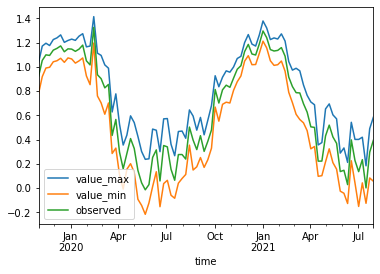

In [44]:
df_pred.resample('7D').mean().plot()

In [23]:
#exports
def plot_pred_sample(
    df_pred: pd.DataFrame,
    df_target: pd.DataFrame=None,
    n_obvs: int=48*5
):
    rand_start_idx = randint(0, df_pred.shape[0]-1)  
    rand_end_idx = rand_start_idx + n_obvs

    # Plotting
    fig, ax = plt.subplots(dpi=150)

    df_pred.iloc[rand_start_idx:rand_end_idx][['value_max', 'value_min']].plot(ax=ax, legend=False)
    
    if df_target is not None:
        df_target.iloc[rand_start_idx:rand_end_idx][['value_max', 'value_min']].plot(ax=ax, color='k', linestyle='--', linewidth=0.5, legend=False)

    ax.set_xlabel('')
    ax.set_ylabel('Net Demand (MW)')

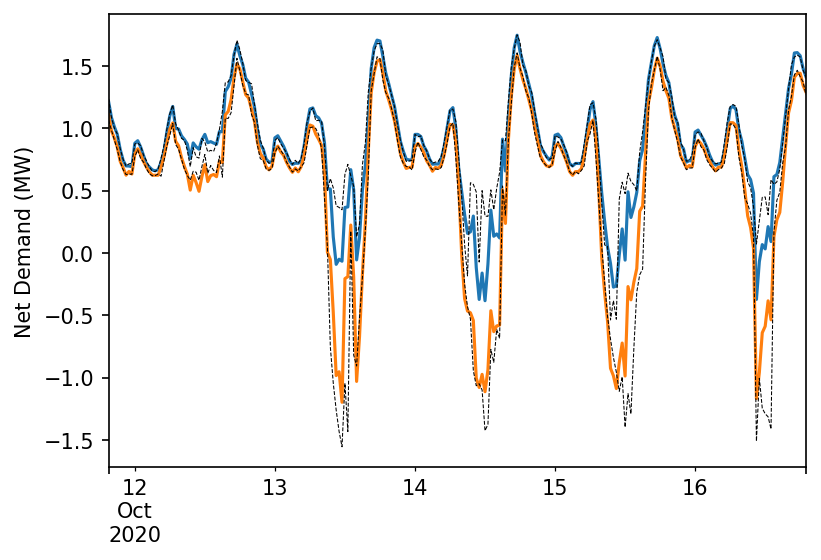

In [26]:
plot_pred_sample(df_pred, df_target)

In [59]:
df_pred[df_pred.isnull().sum(axis=1)>0]

,value_max,value_min,value_mean
time,,,
2019-12-02 17:30:00,2.117328,NaN,1.924675
2020-01-19 18:00:00,2.094934,NaN,1.926116
2020-01-20 18:00:00,2.094891,NaN,1.933557
2020-01-20 18:30:00,2.072565,NaN,1.926254
2020-02-15 17:30:00,NaN,1.882554,2.088478
...,...,...,...
2021-07-07 08:00:00,NaN,1.887277,2.194076
2021-07-17 09:30:00,NaN,-1.266075,-1.093210
2021-07-21 09:30:00,NaN,-1.243962,-1.097156


In [44]:
df_target.subtract(df_pred).dropna(axis=1, how='all')

,value_max,value_min
time,,
2019-11-01 00:00:00,-0.009777,0.042535
2019-11-01 00:30:00,0.006996,-0.012020
2019-11-01 01:00:00,0.003379,-0.009062
2019-11-01 01:30:00,-0.001497,0.015408
2019-11-01 02:00:00,-0.022839,0.004070
...,...,...
2021-07-31 21:30:00,0.018690,-0.018000
2021-07-31 22:00:00,0.001340,-0.018345
2021-07-31 22:30:00,-0.011953,0.017823


In [38]:
df_pred['value_max']#, df_pred['value_min']

time
2019-11-01 00:00:00    1.155128
2019-11-01 00:30:00    1.132441
2019-11-01 01:00:00    1.043793
2019-11-01 01:30:00    0.960227
2019-11-01 02:00:00    0.928022
                         ...   
2021-07-31 21:30:00    0.792792
2021-07-31 22:00:00    0.714979
2021-07-31 22:30:00    0.658257
2021-07-31 23:00:00    0.650620
2021-07-31 23:30:00    0.623457
Name: value_max, Length: 30672, dtype: float64

In [10]:
#exports
def save_params(input_data, fp):
    with open(fp, 'w') as f:
        yaml.dump(input_data, f, sort_keys=False)
        
    return

In [1]:
fp = '../data/params/test.yml'
save = False

if save == True:
    save_params(input_data, fp)

In [12]:
#exports
def load_params(fp):
    with open(fp, 'r') as f:
        input_data = yaml.load(f, Loader=yaml.FullLoader)
        
    return input_data

In [13]:
input_data = load_params(fp)
    
JSON(input_data)

<IPython.core.display.JSON object>

In [108]:
#hide
from nbdev.export import notebook2script
    
notebook2script()

Converted 01-data-processing.ipynb.
Converted 02-spatial-analysis.ipynb.
Converted 03a-feature-generation.ipynb.
Converted 03b-eda.ipynb.
Converted 04-model-suite.ipynb.
Converted 05-submission.ipynb.
Converted 06-experiments.ipynb.
Converted 07-testing.ipynb.
